# CSE253 PA3 - Design a CNN (Version 1) 

With a simple 5-layer CNN, we achieved up to 87% validation accuracy, 83% test accuracy and ensemble test accuracy of 87%.

We will now try to (1) widen, (2) deepen it.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import timeit
import time
import platform
import random
import pickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.4


In [2]:
import torchvision.transforms as transforms

class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 49000
NUM_VAL = 1000
NUM_TRAIN_SMALL=1000

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))
loader_train_small = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True, 
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                          transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
cpu_dtype = torch.FloatTensor # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

Size of CFAR10 Train Set:  50000
 frog truck truck  deer   car   car  bird horse  ship   cat  deer horse horse  bird truck truck truck   cat  bird  frog  deer   cat  frog  frog  bird  frog   cat   dog  deer plane plane truck   car   cat  deer plane   cat horse   cat   cat   dog  bird  bird horse   car   car   car  bird  bird plane truck   dog horse truck  bird  bird   dog  bird  deer   cat   car   car  ship  bird


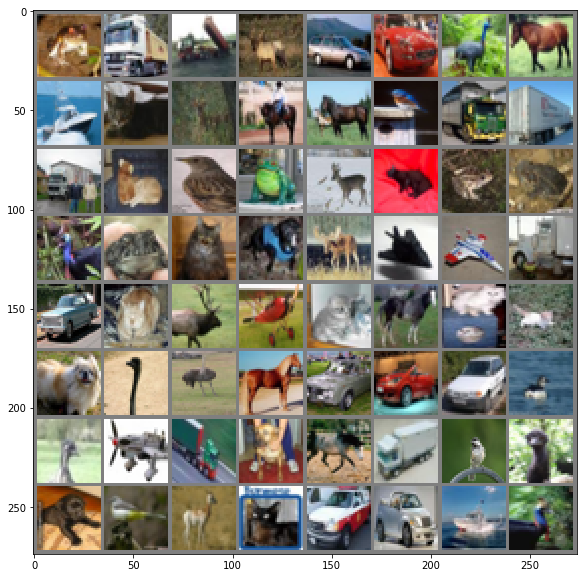

In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

print ("Size of CFAR10 Train Set: ", len(cifar10_train))
    
# get some random training images
dataiter = iter(loader_train)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(64)))

In [56]:
def train_simple(model, loss_fn, optimizer, num_epochs = 10, verbose=False):
    # Train the model - output validation and train accuracy every epoch
    
    train_history = []   # this will store train accuracy, val accuracy and loss for every epoch

    # scheduler = StepLR(optimizer, step_size=5, gamma=0.9)   # decay lr by 0.9 very 5 epochs 
    scheduler = StepLR(optimizer, step_size=1, gamma=0.95)   # decay lr by 0.95 every epoch 
    
    for epoch in range(num_epochs):        
        
        scheduler.step()    
        model.train()
        
        train_lossSum = 0 
        train_total = 0
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            train_total += y_var.size(0)

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            train_lossSum += loss.data[0]  # Accumulate loss over epoch
            
            if (t + 1) % print_every == 0 and verbose:
                print('t = %d, loss = %.6f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       
        # We calculate validation and training accuracy at the end of every epoch
        val_acc = check_accuracy(model, loader_val) 
        train_acc = check_accuracy(model, loader_train_small)
       
        if verbose:
            print("epoch {}/{}: train acc={:.3f}, val acc={:.3f}, loss={:.8f}".format(epoch + 1, \
                                        num_epochs, train_acc,val_acc,train_lossSum/train_total))
        train_history.append([train_acc,val_acc,train_lossSum/train_total])
        
    return train_history 


def train_detailed(model, loss_fn, optimizer, filename, num_epochs = 10, verbose=False):
    # Train the model in greater detail - output validation and train accuracy every epoch
    
    train_history = []   # this will store train accuracy, val accuracy and loss for every epoch
    best_val_acc = 0.0  # initialize best_val_acc

    # scheduler = StepLR(optimizer, step_size=5, gamma=0.9)   # decay lr by 0.9 very 5 epochs 
    scheduler = StepLR(optimizer, step_size=1, gamma=0.95)   # decay lr by 0.95 every epoch 
    
    for epoch in range(num_epochs):        
        
        scheduler.step()    
        model.train()
        
        train_lossSum = 0 
        train_total = 0
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            train_total += y_var.size(0)

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            train_lossSum += loss.data[0]  # Accumulate loss over epoch
            
            if (t + 1) % print_every == 0 and verbose:
                print('t = %d, loss = %.6f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       
        # We calculate validation and training accuracy at the end of every epoch
        val_acc = check_accuracy(model, loader_val) 
        train_acc = check_accuracy(model, loader_train_small)

        # Compute validation loss    
        val_lossSum = 0.0
        val_total = 0
        for t, (x, y) in enumerate(loader_val):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            val_total += y_var.size(0)
            
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            val_lossSum += loss.data[0]
        
        if val_acc > best_val_acc:  
            # save your model 
            print ("better val accuracy: update model.")
            torch.save(model.state_dict(), filename)
            best_val_acc = val_acc 

        if verbose:
            print("epoch {}/{}: train acc={:.3f}, val acc={:.3f}, train loss={:.8f}, val loss ={:.8f}". \
                  format(epoch + 1, num_epochs, train_acc,val_acc,train_lossSum/train_total, val_lossSum/val_total))
    
        train_history.append([train_acc,val_acc,train_lossSum/train_total,val_lossSum/val_total])
        
    return best_val_acc, train_history 
        

def check_accuracy(model, loader, verbose=False):
    if verbose:
        if loader.dataset.train:
            print('Checking accuracy on validation set')
        else:
            print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc


## Network Architecture Design



In [47]:
def generator():

    # Model - 5 layer Conv Layers

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(16384,1024),  # 5408=128*16*16 input size
                    nn.BatchNorm1d(1024),
                    nn.ReLU(inplace=True),
                    nn.Linear(1024,10),
                    )
    
    
    return model

### Dimension Check

Handy to check dimension when putting together a CNN architecture

In [48]:
model = generator().type(gpu_dtype)

x_gpu = torch.randn(64, 3, 32, 32).type(gpu_dtype)
x_var_gpu = Variable(x_gpu.type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
ans = model(x_var_gpu)        # Feed it through the model! 

print (ans.shape)

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 10]))

torch.Size([64, 10])


True

### Coarse Accessment

In [49]:
stat = []
epochs = 3

start = time.time()
max_count = 20
for count in range(max_count):
    reg = 1e-10
    lr = 10**random.uniform(-5,-2)
    
    model = generator().type(gpu_dtype)
    
    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    train_simple(model, loss_fn, optimizer, num_epochs=epochs)
    val_acc = check_accuracy(model, loader_val)
    
    print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc))
    stat.append([lr, reg, val_acc])

end = time.time()
    
print('Training time per epochs: {:.2f} sec'.format((end-start)/(epochs*max_count)))

sorted_stat = sorted(stat, key=lambda x: x[0], reverse=True)
print ("In descending order of learning rate:")
for lr, reg, val_acc in sorted_stat:
    print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc)) 

lr = 5.57049e-03, reg = 1.00000e-10, validation accuracy is 0.78500000  
lr = 3.75867e-03, reg = 1.00000e-10, validation accuracy is 0.79900000  
lr = 2.78694e-05, reg = 1.00000e-10, validation accuracy is 0.72500000  
lr = 1.61606e-04, reg = 1.00000e-10, validation accuracy is 0.79500000  
lr = 7.33249e-03, reg = 1.00000e-10, validation accuracy is 0.78800000  
lr = 7.67320e-04, reg = 1.00000e-10, validation accuracy is 0.81900000  
lr = 1.56744e-05, reg = 1.00000e-10, validation accuracy is 0.71500000  
lr = 5.97765e-03, reg = 1.00000e-10, validation accuracy is 0.79800000  
lr = 2.27851e-05, reg = 1.00000e-10, validation accuracy is 0.72300000  
lr = 1.38388e-04, reg = 1.00000e-10, validation accuracy is 0.79900000  
lr = 1.45928e-03, reg = 1.00000e-10, validation accuracy is 0.81000000  
lr = 3.55603e-03, reg = 1.00000e-10, validation accuracy is 0.79700000  
lr = 1.01153e-03, reg = 1.00000e-10, validation accuracy is 0.80600000  
lr = 3.46317e-04, reg = 1.00000e-10, validation acc

## Architecture Evaluation

The new model has to improve over this baseline for the Simple 5-Layer CNN:

lr = 8.95371e-03, reg = 1.00000e-10, validation accuracy is 0.76800000  
lr = 6.77483e-03, reg = 1.00000e-10, validation accuracy is 0.76600000  
lr = 3.76863e-03, reg = 1.00000e-10, validation accuracy is 0.80700000  
lr = 1.80528e-03, reg = 1.00000e-10, validation accuracy is 0.81700000  
lr = 1.79516e-03, reg = 1.00000e-10, validation accuracy is 0.80600000  
lr = 1.39727e-03, reg = 1.00000e-10, validation accuracy is 0.79400000  
lr = 9.51133e-04, reg = 1.00000e-10, validation accuracy is 0.81500000  
lr = 4.62437e-04, reg = 1.00000e-10, validation accuracy is 0.79300000  
lr = 4.38487e-04, reg = 1.00000e-10, validation accuracy is 0.79500000  
lr = 4.30372e-04, reg = 1.00000e-10, validation accuracy is 0.77600000  
lr = 2.80851e-04, reg = 1.00000e-10, validation accuracy is 0.77500000  
lr = 7.11403e-05, reg = 1.00000e-10, validation accuracy is 0.72400000  
lr = 5.77489e-05, reg = 1.00000e-10, validation accuracy is 0.71600000  
lr = 3.97000e-05, reg = 1.00000e-10, validation accuracy is 0.70400000  
lr = 2.78049e-05, reg = 1.00000e-10, validation accuracy is 0.68600000  
lr = 1.80059e-05, reg = 1.00000e-10, validation accuracy is 0.66100000  
lr = 1.58900e-05, reg = 1.00000e-10, validation accuracy is 0.64800000  
lr = 1.13120e-05, reg = 1.00000e-10, validation accuracy is 0.63900000  
lr = 1.11524e-05, reg = 1.00000e-10, validation accuracy is 0.62300000  
lr = 1.04488e-05, reg = 1.00000e-10, validation accuracy is 0.62500000  

Training time per epochs: 8.0 sec 

### Wider 5-layer model (More Accurate but Slower)
lr = 7.33249e-03, reg = 1.00000e-10, validation accuracy is 0.78800000  
** lr = 5.97765e-03, reg = 1.00000e-10, validation accuracy is 0.79800000 **  
lr = 5.57049e-03, reg = 1.00000e-10, validation accuracy is 0.78500000  
** lr = 3.75867e-03, reg = 1.00000e-10, validation accuracy is 0.79900000 **  
** lr = 3.55603e-03, reg = 1.00000e-10, validation accuracy is 0.79700000 **  
** lr = 1.45928e-03, reg = 1.00000e-10, validation accuracy is 0.81000000 **  
** lr = 1.01153e-03, reg = 1.00000e-10, validation accuracy is 0.80600000 **  
** lr = 9.12946e-04, reg = 1.00000e-10, validation accuracy is 0.81100000 **  
** lr = 7.67320e-04, reg = 1.00000e-10, validation accuracy is 0.81900000 **  
** lr = 6.85406e-04, reg = 1.00000e-10, validation accuracy is 0.82000000 **  
** lr = 3.46317e-04, reg = 1.00000e-10, validation accuracy is 0.81800000 **  
** lr = 1.61606e-04, reg = 1.00000e-10, validation accuracy is 0.79500000 **  
** lr = 1.38388e-04, reg = 1.00000e-10, validation accuracy is 0.79900000 **  
lr = 4.90353e-05, reg = 1.00000e-10, validation accuracy is 0.72900000  
lr = 3.38636e-05, reg = 1.00000e-10, validation accuracy is 0.72600000  
lr = 2.86737e-05, reg = 1.00000e-10, validation accuracy is 0.72100000  
lr = 2.78694e-05, reg = 1.00000e-10, validation accuracy is 0.72500000  
lr = 2.27851e-05, reg = 1.00000e-10, validation accuracy is 0.72300000  
lr = 1.56744e-05, reg = 1.00000e-10, validation accuracy is 0.71500000  
lr = 1.44395e-05, reg = 1.00000e-10, validation accuracy is 0.69800000  

Training time per epochs: 19.22 sec

## Hyperparameter Optimization

We perform random search over permutations of learning rate and regularization. At 20 seconds per epoch, we can do 50 permutations which will last 50 minutes.

In [53]:
stat = []
epoch = 3

start = time.time()
max_count = 50

for count in range(max_count):
    reg = 10**random.uniform(-10,-5)
    lr = random.uniform(1e-4, 6e-3)
    
    model = generator().type(gpu_dtype)
    
    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    train_simple(model, loss_fn, optimizer, num_epochs=epochs)
    val_acc = check_accuracy(model, loader_val)
    
    print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc))
    stat.append([lr, reg, val_acc])

end = time.time()
    
print('Training time per epochs: {:.2f} sec'.format((end-start)/(epochs*max_count)))

sorted_stat = sorted(stat, key=lambda x: x[0], reverse=True)
print ("In descending order of learning rate:")
for lr, reg, val_acc in sorted_stat:
    print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc)) 

lr = 5.51387e-03, reg = 7.82433e-10, validation accuracy is 0.79400000  
lr = 4.51115e-03, reg = 1.42377e-06, validation accuracy is 0.80500000  
lr = 3.65379e-03, reg = 8.96180e-07, validation accuracy is 0.79500000  
lr = 1.86575e-03, reg = 1.47910e-10, validation accuracy is 0.82500000  
lr = 5.55065e-03, reg = 6.12486e-08, validation accuracy is 0.78900000  
lr = 2.19012e-03, reg = 2.07652e-07, validation accuracy is 0.79200000  
lr = 4.22817e-03, reg = 2.47843e-06, validation accuracy is 0.77500000  
lr = 1.57883e-03, reg = 1.92869e-10, validation accuracy is 0.81600000  
lr = 2.92231e-03, reg = 2.33612e-09, validation accuracy is 0.81200000  
lr = 4.60279e-03, reg = 3.60766e-10, validation accuracy is 0.79900000  
lr = 5.26674e-03, reg = 2.25906e-06, validation accuracy is 0.75100000  
lr = 4.03330e-03, reg = 2.68352e-10, validation accuracy is 0.81400000  
lr = 5.46944e-03, reg = 1.54924e-08, validation accuracy is 0.78500000  
lr = 4.44414e-03, reg = 3.52036e-10, validation acc

### Finetune Learning Rate + Regularization

* In descending order of learning rate:
lr = 5.96576e-03, reg = 7.50314e-08, validation accuracy is 0.78500000  
lr = 5.88078e-03, reg = 5.25642e-08, validation accuracy is 0.78400000  
** lr = 5.83888e-03, reg = 2.40497e-07, validation accuracy is 0.81100000 **  
lr = 5.83270e-03, reg = 2.59891e-10, validation accuracy is 0.78500000  
lr = 5.55065e-03, reg = 6.12486e-08, validation accuracy is 0.78900000  
lr = 5.51387e-03, reg = 7.82433e-10, validation accuracy is 0.79400000  
lr = 5.46944e-03, reg = 1.54924e-08, validation accuracy is 0.78500000  
lr = 5.26674e-03, reg = 2.25906e-06, validation accuracy is 0.75100000  
lr = 4.95624e-03, reg = 1.15743e-08, validation accuracy is 0.80300000  
lr = 4.92386e-03, reg = 1.43745e-06, validation accuracy is 0.79100000  
lr = 4.78328e-03, reg = 4.54586e-06, validation accuracy is 0.78900000  
lr = 4.75852e-03, reg = 1.46203e-10, validation accuracy is 0.79200000  
lr = 4.74894e-03, reg = 1.27193e-06, validation accuracy is 0.80600000  
lr = 4.70541e-03, reg = 1.57678e-10, validation accuracy is 0.80600000  
lr = 4.60279e-03, reg = 3.60766e-10, validation accuracy is 0.79900000  
lr = 4.58362e-03, reg = 3.38380e-10, validation accuracy is 0.79800000  
lr = 4.56109e-03, reg = 2.35794e-10, validation accuracy is 0.79900000  
lr = 4.51115e-03, reg = 1.42377e-06, validation accuracy is 0.80500000  
lr = 4.44414e-03, reg = 3.52036e-10, validation accuracy is 0.78500000  
lr = 4.22817e-03, reg = 2.47843e-06, validation accuracy is 0.77500000  
** lr = 4.03330e-03, reg = 2.68352e-10, validation accuracy is 0.81400000 **  
lr = 3.99083e-03, reg = 5.39475e-09, validation accuracy is 0.80100000  
lr = 3.97015e-03, reg = 4.39243e-08, validation accuracy is 0.79200000  
lr = 3.96012e-03, reg = 5.91026e-08, validation accuracy is 0.79300000  
lr = 3.67567e-03, reg = 1.11243e-09, validation accuracy is 0.79800000  
lr = 3.65379e-03, reg = 8.96180e-07, validation accuracy is 0.79500000  
lr = 3.50789e-03, reg = 5.70949e-09, validation accuracy is 0.79800000  
lr = 3.35608e-03, reg = 6.33333e-10, validation accuracy is 0.80400000  
lr = 3.32951e-03, reg = 1.81836e-09, validation accuracy is 0.80900000  
lr = 3.27486e-03, reg = 1.67531e-10, validation accuracy is 0.79400000  
** lr = 3.26897e-03, reg = 1.14853e-09, validation accuracy is 0.81900000 **  
lr = 3.05623e-03, reg = 2.32692e-06, validation accuracy is 0.79000000  
lr = 2.96409e-03, reg = 3.99399e-08, validation accuracy is 0.80900000  
** lr = 2.92231e-03, reg = 2.33612e-09, validation accuracy is 0.81200000 **  
lr = 2.51176e-03, reg = 1.55394e-09, validation accuracy is 0.79100000  
lr = 2.19012e-03, reg = 2.07652e-07, validation accuracy is 0.79200000  
** lr = 2.10335e-03, reg = 9.47065e-08, validation accuracy is 0.82100000 **  
lr = 2.03995e-03, reg = 7.07108e-08, validation accuracy is 0.79600000  
lr = 2.02457e-03, reg = 1.91485e-07, validation accuracy is 0.80800000  
** lr = 1.86575e-03, reg = 1.47910e-10, validation accuracy is 0.82500000 **  
** lr = 1.58005e-03, reg = 2.10759e-08, validation accuracy is 0.81000000 **  
** lr = 1.57883e-03, reg = 1.92869e-10, validation accuracy is 0.81600000 **  
** lr = 1.53026e-03, reg = 1.89939e-08, validation accuracy is 0.81800000 **  
** lr = 1.28424e-03, reg = 1.02852e-10, validation accuracy is 0.81800000 **  
** lr = 1.18544e-03, reg = 4.46988e-06, validation accuracy is 0.80600000 **  
** lr = 1.11437e-03, reg = 2.58565e-08, validation accuracy is 0.81400000 **  
** lr = 9.21126e-04, reg = 1.00872e-08, validation accuracy is 0.81700000 **  
** lr = 5.05754e-04, reg = 5.16894e-10, validation accuracy is 0.82900000 **  
** lr = 2.40105e-04, reg = 8.45501e-08, validation accuracy is 0.82800000 **  
lr = 1.81054e-04, reg = 3.23140e-08, validation accuracy is 0.79200000  


## Fine Tuning with Long Training

At 20 seconds per epoch, a 50 epoch training will last 17 minutes. We can thus do 3 permutations per hour and about 40 permutations in 12 hours.

    reg = 10**random.uniform(-11, -7)
    lr = 10**random.uniform(-4,-2)

better val accuracy: update model.
better val accuracy: update model.
lr = 0.0006529985835150227, reg = 3.890491942540636e-08.
Best validation accuracy is 0.813. Training time for 2 epochs: 39.41 sec


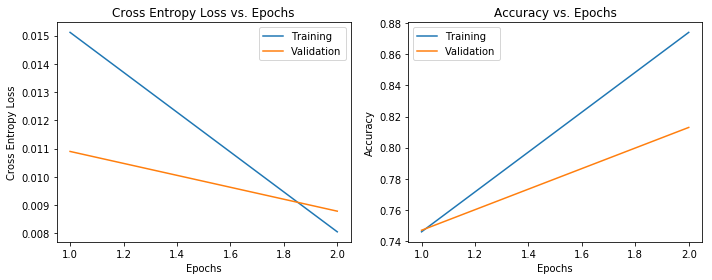

better val accuracy: update model.
better val accuracy: update model.
lr = 0.0003619501669552983, reg = 5.426998735816345e-10.
Best validation accuracy is 0.817. Training time for 2 epochs: 39.73 sec


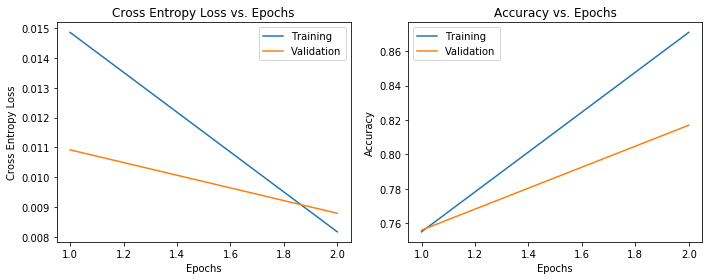

better val accuracy: update model.
better val accuracy: update model.
lr = 0.001296876365079762, reg = 3.6284291260948086e-08.
Best validation accuracy is 0.8. Training time for 2 epochs: 39.61 sec


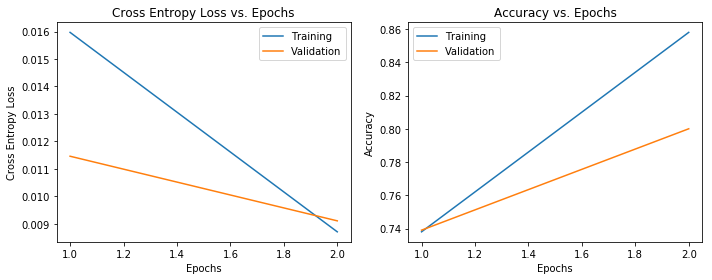

KeyboardInterrupt: 

In [57]:
epochs = 2

max_count = 50  # Run random 
for count in range(max_count):
    
    reg = 10**random.uniform(-11, -7)
    lr = 10**random.uniform(-4,-2)
    
    best_val_acc=0.0
    model = generator().type(gpu_dtype)

    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    
# lr=0.0012 gives consistent 83+% test accuracy
# optimizer = optim.Adam(model.parameters(), lr=0.0012, weight_decay=reg)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

    start = time.time()

    file_name = 'm1-50ep-results/model1'+'_reg='+str('{:.4e}'.format(reg))+'lr='+str('{:.4e}'.format(lr)) \
            +'ep='+str(epochs)+'bestacc.pt'
    best_val_acc, results = train_detailed(model, loss_fn, optimizer, file_name, 
                                                    num_epochs=epochs, verbose=False)

    end = time.time()

    print('lr = {}, reg = {}.'.format(lr, reg))    
    print('Best validation accuracy is {0}. Training time for {1} epochs: {2:.2f} sec'.format(best_val_acc, 
                                                                                              epochs, end-start))
    # Plot out the accuracies and losses
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(list(range(1,len(np.array(results)[:,2])+1)), np.array(results)[:,2], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,3])+1)), np.array(results)[:,3], label='Validation')
    plt.title('Cross Entropy Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list(range(1,len(np.array(results)[:,0])+1)), np.array(results)[:,0], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,1])+1)), np.array(results)[:,1], label='Validation')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    #plt.savefig('sgd_model_plot_batch_norm_hidden_256x256.png')
    plt.show()